In [1]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams.update(
    {"figure.autolayout": True, "font.family": "serif", "text.usetex": True}
)
s = ctrl.TransferFunction.s
G = 1 / (s**2 + 10 * s + 20)
sys = ctrl.ss(G)
G1 = 3 / (s**2 + 10.1 * s + 12)
sys2 = ctrl.ss(G1)
A, B, C, D = ctrl.ssdata(sys)

Observer Design

In [2]:
# Inspect system matrix shapes
print("A:", A.shape, "B:", B.shape, "C:", C.shape, "D:", D.shape)
print("A=\n", A)
print("B=\n", B)
print("C=\n", C)
print("D=\n", D)

A: (2, 2) B: (2, 1) C: (1, 2) D: (1, 1)
A=
 [[-10. -20.]
 [  1.   0.]]
B=
 [[1.]
 [0.]]
C=
 [[0. 1.]]
D=
 [[0.]]


Shapes -> A: (2, 2) B: (2, 1) C: (1, 2) L: (2, 1)
Raw z shape returned: (4, 1, 500)
Squeezed z shape: (4, 500)


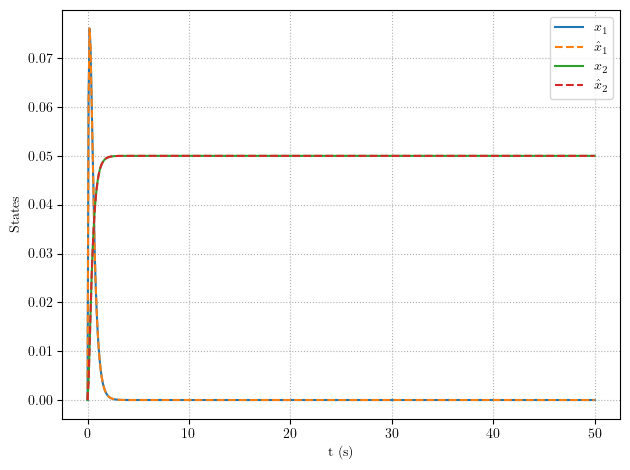

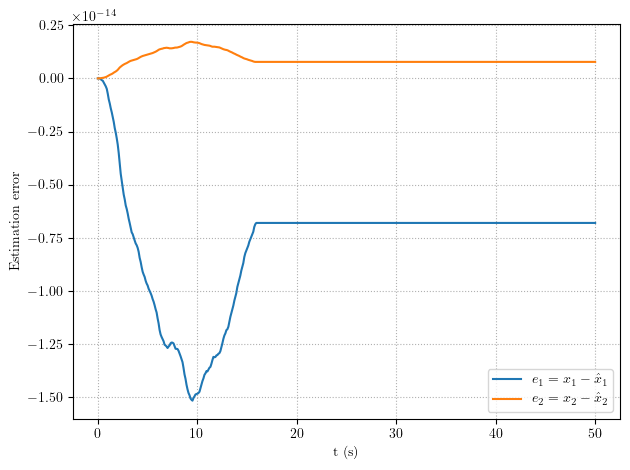

In [3]:
# Correct plant + observer simulation (coupled system)
# Luenberger observer with desired eigenvalues for (A - L C)

n = A.shape[0]
C = np.asarray(C)
# Ensure C is (1, n)
if C.shape != (1, n):
    C = C.reshape(1, n)

# Observer gain: acker on transposed system (dual) returns a row vector; reshape to column (n,1)
L_row = ctrl.acker(A.T, C.T, [-0.2, -1])  # shape (n,)
L = L_row.reshape(n, 1)  # (n,1)

print("Shapes -> A:", A.shape, "B:", B.shape, "C:", C.shape, "L:", L.shape)

# Augmented dynamics: z = [x; x_hat]
LC = L @ C  # (n,n)
A_aug = np.block([[A, np.zeros_like(A)], [LC, A - LC]])
B_aug = np.vstack((B, B))
C_aug = np.eye(n * 2)
D_aug = np.zeros((C_aug.shape[0], B.shape[1]))

sys_aug = ctrl.ss(A_aug, B_aug, C_aug, D_aug)

# Simulate unit step input
t = np.linspace(0, 50, 500)
t, _, z = ctrl.step_response(sys_aug, t, return_states=True)
print("Raw z shape returned:", z.shape)

# Some versions of python-control return state array with an extra singleton dimension for SISO: (n, 1, N)
if z.ndim == 3 and z.shape[1] == 1:
    z = z[:, 0, :]  # squeeze middle dimension
    print("Squeezed z shape:", z.shape)

# Split true and estimated states
x_true = z[0:n, :]
x_hat = z[n : 2 * n, :]

# Plot true vs estimated states (flatten rows to 1D)
plt.figure()
plt.plot(t, x_true[0].ravel(), label=r"$x_1$")
plt.plot(t, x_hat[0].ravel(), "--", label=r"$\hat{x}_1$")
plt.plot(t, x_true[1].ravel(), label=r"$x_2$")
plt.plot(t, x_hat[1].ravel(), "--", label=r"$\hat{x}_2$")
plt.xlabel("t (s)")
plt.ylabel("States")
plt.legend()
plt.grid(True, which="both", ls=":")

# Plot estimation error
plt.figure()
e = x_true - x_hat
plt.plot(t, e[0].ravel(), label=r"$e_1 = x_1 - \hat{x}_1$")
plt.plot(t, e[1].ravel(), label=r"$e_2 = x_2 - \hat{x}_2$")
plt.xlabel("t (s)")
plt.ylabel("Estimation error")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()

### Luenberger observer
The Luenberger observer is designed using pole placement for $(A-LC)$ at $p_1$ and $p_2$. We simulate the coupled augmented system
$$
\begin{bmatrix} x \\ \hat x \end{bmatrix}' = \begin{bmatrix} A & 0 \\ LC & A-LC \end{bmatrix} \begin{bmatrix} x \\ \hat x \end{bmatrix} + \begin{bmatrix} B \\ B \end{bmatrix} u,
$$
with a unit step input $u(t)$. The first plot overlays $x$ and $\hat x$; the second shows the estimation error $e = x - \hat x$.



### Full-state feedback via pole placement (with observer)
We now design a state-feedback controller using pole placement for the plant matrix $(A, B)$ and combine it with the observer. Using the separation principle, the closed-loop dynamics in the coordinates $[x; e]$ with $e = x - \hat x$ are
$$
\begin{bmatrix} x \\ e \end{bmatrix}' =
\begin{bmatrix} A - BK & BK \\ 0 & A - LC \end{bmatrix}
\begin{bmatrix} x \\ e \end{bmatrix} +
\begin{bmatrix} B \\ 0 \end{bmatrix} N_{\mathrm{bar}}\, r\,,
$$
where $u = -K\,\hat x + N_{\mathrm{bar}} r$ and $N_{\mathrm{bar}}$ is chosen so that a unit step reference yields unit steady-state output: 
$N_{\mathrm{bar}} = -1 /\big(C(A - BK)^{-1}B\big)$ for SISO, $D=0$.

We simulate a unit step in $r$, and plot output $y$, states $x$ and their estimates $\hat x = x - e$, and the control input $u$.

K: [[ 5. 30.]] L: [-20.   5.] Nbar: [[50.]]


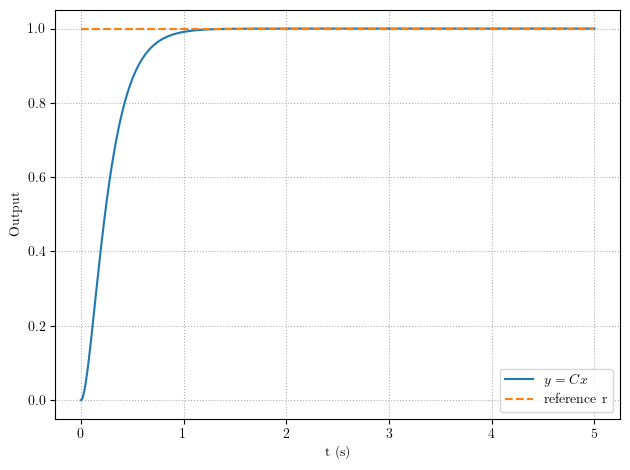

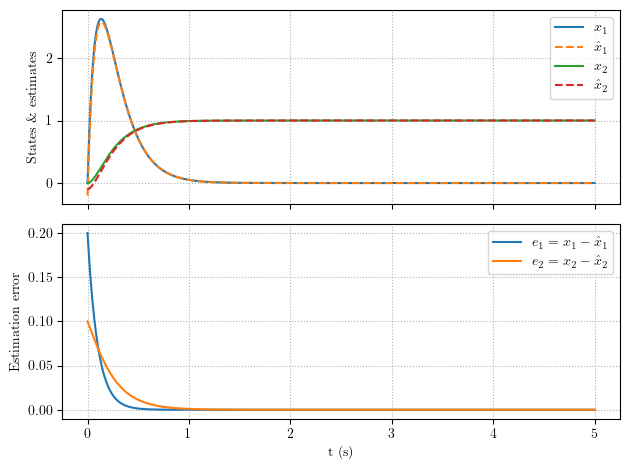

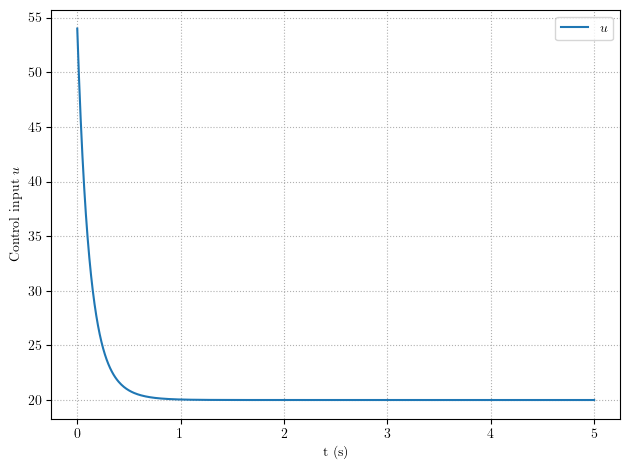

In [ ]:
# State-feedback controller with observer (separation principle)
n = A.shape[0]
C_row = np.asarray(C).reshape(1, n)

# Design state-feedback K: choose faster poles than observer for good estimation first
K = ctrl.place(A, B, [-5, -10]).reshape(1, n)  # K row vector

# Observer poles (already used above); reuse or redefine
L = ctrl.place(A.T, C_row.T, [-10, -5]).reshape(n, 1)  # faster observer

# Compute Nbar for unit step reference tracking (SISO assumption)
A_cl = A - B @ K
Nbar = -1.0 / (C_row @ np.linalg.inv(A_cl) @ B)
Nbar = Nbar  # scalar
print("K:", K, "L:", L.ravel(), "Nbar:", Nbar)

# Initial conditions: x(0) = 0, e(0) = [0.2, -0.1] (nonzero estimation error)
x0 = np.zeros(n)
e0 = np.array([0.2, 0.1])
X0 = np.concatenate([x0, e0])

# Build augmented system for [x; e] where e = x - x_hat
A_aug = np.block([[A - B @ K, B @ K], [np.zeros((n, n)), A - L @ C_row]])
B_aug = np.vstack((B.reshape(n, 1) * Nbar, np.zeros((n, 1))))
C_aug = np.eye(2 * n)
D_aug = np.zeros((2 * n, 1))

sys_sep = ctrl.ss(A_aug, B_aug, C_aug, D_aug)

T = np.linspace(0, 5, 600)
T, z = ctrl.forced_response(sys_sep, T, np.ones_like(T), X0=X0)
if z.ndim == 3 and z.shape[1] == 1:
    z = z[:, 0, :]

x = z[0:n, :]
e = z[n : 2 * n, :]
x_hat = x - e

r = np.ones_like(T)
y = (C_row @ x).ravel()
u = (-K @ x_hat + Nbar * r).ravel()

plt.figure()
plt.plot(T, y, label=r"$y=Cx$")
plt.plot(T, r, "--", label="reference r")
plt.xlabel("t (s)")
plt.ylabel("Output")
plt.legend()
plt.grid(True, which="both", ls=":")

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(T, x[0], label=r"$x_1$")
ax1.plot(T, x_hat[0], "--", label=r"$\hat{x}_1$")
ax1.plot(T, x[1], label=r"$x_2$")
ax1.plot(T, x_hat[1], "--", label=r"$\hat{x}_2$")
ax1.set_ylabel(r"States \& estimates")
ax1.legend()
ax1.grid(True, which="both", ls=":")

ax2.plot(T, e[0], label=r"$e_1 = x_1 - \hat{x}_1$")
ax2.plot(T, e[1], label=r"$e_2 = x_2 - \hat{x}_2$")
ax2.set_xlabel("t (s)")
ax2.set_ylabel("Estimation error")
ax2.legend()
ax2.grid(True, which="both", ls=":")

plt.figure()
plt.plot(T, u, label=r"$u$")
plt.xlabel("t (s)")
plt.ylabel(r"Control input $u$")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()